In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.result_loader import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values

# 26 Finetune resnet18 on food101

Steps: 
- [x] do hypsearch on full dataset
- [x] select random samples (prune randomly)
- [x] select samples according to prediction depth metric

## A. Experiment config

### Config file

In [2]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: ocelot
  gpu_ids: [0]
  runs_per_gpu: 1
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: trainer.optimizer.kwargs.lr
    vals: [5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  - parameter: trainer.optimizer.kwargs.weight_decay
    vals: [0.0, 1e-3, 1e-4]
    
start_num: 0

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '26-fo101-hyps'
    experiment_type: startnum_${start_num}
    experiment_name: food101-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-hypsearch
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 30
    val_every: 1
    early_stopping_patience: 15
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 1e-3
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: food101
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
"""
cfg = OmegaConf.create(config_yaml)

In [3]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

### Sweep result

In [4]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 26-fo101-hyps(0)
Exp. Name: food101-26-fo101-hyps.0-resnet18-ft-hypsearch
Training setup: finetune
Model name: timmmodel
Dataset name: food101
Sweep type: grid
  trainer.optimizer.kwargs.lr: [0.005, 0.001, 0.0005, 0.0001, 5e-05, 1e-05]
  trainer.optimizer.kwargs.weight_decay: [0.0, 0.001, 0.0001]
Seeds: [0]
Num. jobs: 18
Config updated: 2023-03-18 09:03:06
Sweep started:  2023-03-18 09:03:36



In [5]:
failed_jobs = sweepr.get_failed_jobs()
failed_jobs # No failed jobs

([], {})

In [6]:
sweepr.get_summary().sort_values(by='best_val_score', ascending=True)

,best_epoch,best_val_score,trainer.optimizer.kwargs.lr,trainer.optimizer.kwargs.weight_decay,seed
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-5e-05-weight_decay-0-seed-0--230319_005019,8,0.823297,0.00005,0.0000,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-5e-05-weight_decay-0.0001-seed-0--230319_034247,8,0.823297,0.00005,0.0001,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-5e-05-weight_decay-0.001-seed-0--230319_021626,8,0.823334,0.00005,0.0010,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-0.0001-weight_decay-0.001-seed-0--230318_221925,5,0.831569,0.00010,0.0010,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-0.0001-weight_decay-0-seed-0--230318_210303,5,0.831798,0.00010,0.0000,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-0.0001-weight_decay-0.0001-seed-0--230318_233446,5,0.831798,0.00010,0.0001,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-1e-05-weight_decay-0-seed-0--230319_050759,30,0.842095,0.00001,0.0000,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-1e-05-weight_decay-0.0001-seed-0--230319_084615,30,0.842095,0.00001,0.0001,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-1e-05-weight_decay-0.001-seed-0--230319_065621,30,0.842095,0.00001,0.0010,0
food101-26-fo101-hyps.0-resnet18-ft-hypsearch--lr-0.0005-weight_decay-0.001-seed-0--230318_183420,4,1.069409,0.00050,0.0010,0


## B. Random subsample sweep

In [7]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: ocelot
  gpu_ids: [0]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
    
start_num: 1

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '26.1-fo101-randsample'
    experiment_type: startnum_${start_num}
    experiment_name: food101-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-randomsubsample
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 50
    val_every: 1
    early_stopping_patience: 10
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 5e-5
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: food101
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
    sample_selector:
      name: random
      kwargs:
        fraction: 0.1

"""
cfg = OmegaConf.create(config_yaml)

In [8]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run_sweep.py --config-name food101-26.1-fo101-randsample.1-resnet18-ft-randomsubsample.yaml


In [9]:
sweepr_randsample = REPO.get_output_loader(cfg)

## B. Random subsample sweep

In [10]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: ocelot
  gpu_ids: [0]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [0]

sweep:
  type: grid
  axes: 
  - parameter: data.sample_selector.kwargs.fraction
    vals: [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
  - parameter: data.sample_selector.kwargs.keep_highest
    vals: [True, False]
    
start_num: 0

config:
  experiment_data:
    entity: fslgroup
    project_name: tflearning
    experiment_tag: '26.2-fo101-pd_subsample'
    experiment_type: startnum_${start_num}
    experiment_name: ${config.data.name}-${config.experiment_data.experiment_tag}.${start_num}-resnet18-ft-pdepthsubsample
    experiment_dir: null
    experiment_notes: 
    seed: 0
    gpu_id: 1
  
  model:
    name: timmmodel
    kwargs:
      name: resnet18
      timm_kwargs:
        pretrained: True
  
  trainer:
    training_setup: finetune
    n_epochs: 50
    val_every: 1
    early_stopping_patience: 10
    save_every: 100e3
    batch_size: 256
    optimizer:
      name: AdamW
      kwargs:
        lr: 5e-5
        weight_decay: 0.0
    loss: crossentropy
    num_workers: 6
  
  data:
    name: food101
    kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      n_px: 224
    sample_selector:
      name: prediction_depth
      kwargs:
        fraction: 0.1
        pred_results_file: /system/user/beck/pwbeck/projects/regularization/tflearning/outputs_scripts/prediction_depth/PD-food101-resnet18--230317_151944/prediction_depth_results.p
        keep_highest: True
"""
cfg = OmegaConf.create(config_yaml)

In [12]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

In [13]:
sweepr_pdsample = REPO.get_output_loader(cfg)


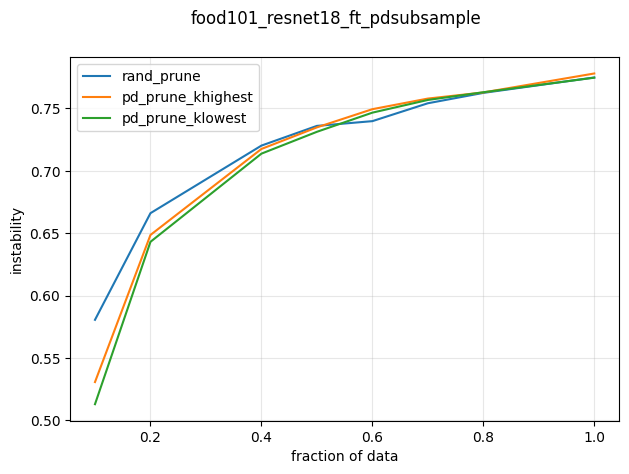

In [17]:
from tflearning.sample_difficulty.plot import plot_pruning_results

f = plot_pruning_results(random_pruning_results=sweepr_randsample,
                         pd_pruning_results=sweepr_pdsample,
                         title='food101_resnet18_ft_pdsubsample',
                         ft_epoch=10,
                         ft_col_sel='Accuracy-top-1',
                         save_format='')